## **A. Introduction**

#### **A.1. Description & Disscusion of the Background**

London is one of the largest metropolises in the world where almost **9 million** people live and it has a population density of **5,701** people per square kilometer. As a resident of the city, I decided to use London in my project. The city is divided into 33 boroughs in total each controlled by a different political party which is often a good indicator for the affluence of the borough.

While London isn't the largest city or the most densely populated, it is extremely expensive and hard for any new business to prosper. It's not unusual for a small independent business to crop up one month and close down the next due to high rent and high competition. I aim to deliver insights into areas that business owners and investors should set up to avoid running themselves out of business. 

We would expect that cheaper areas would be more sought after for new business owners and more expensive areas for those already with a large brand behind them.

When we consider these things, we can create a map and information chart where the real estate index is placed on London and each district is clustered according to the venue density.

#### **A.2. Data Description**

To consider the problem we can list the data I collected below

* I used the Wikipedia page to list all London boroughs with their longitudes and latitudes and political sway 
* I used **Foursquare API** to get the most common venues of given Borough of London 
* I used a public csv file supplied by the London Datastore to find out the average weekly rent of each borough 

In [2]:
from bs4 import BeautifulSoup # this module helps in web scrapping.
import requests
import pandas as pd
from geopy.geocoders import Nominatim
import folium # map rendering library
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
from sklearn.preprocessing import MinMaxScaler

## **B. Methodology**
----

#### **B.1. Creating data table and data pre-processing**

My master data **df** has the main components *Borough, Political control, Population, Area, Average weekly rent, Latitude* and *Longitude* informations of the city.

In [51]:
df = pd.read_csv("London_borough_df.csv")
df.head(5)

,Borough,Political control,Area (sq mi),Population (2019 est)[1],Rent,Latitude,Longitude
0,Barking and Dagenham,Labour,13.93,"212,906",95.516082,51.560,0.1557
1,Barnet,Conservative,33.49,"395,896",101.374365,51.625,-0.1517
2,Bexley,Conservative,23.38,"248,287",NaN,51.454,0.1505
3,Brent,Labour,16.70,"329,771",112.660721,51.558,-0.2817
4,Bromley,Conservative,57.97,"332,336",NaN,51.403,0.0198


Let's group the data by Political Control to help show affluent areas

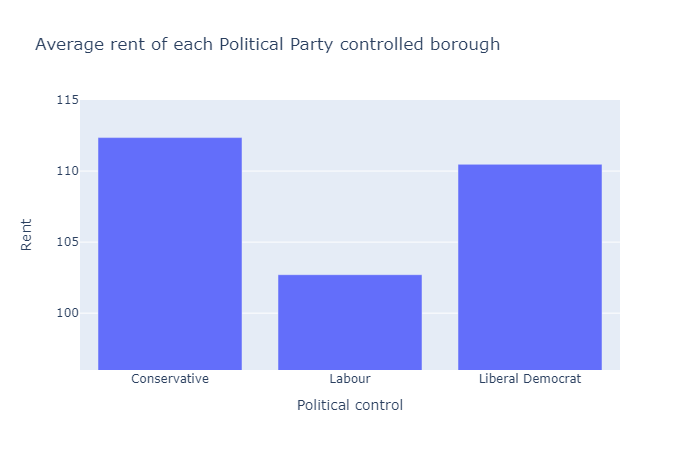

In [4]:
political_control = df.groupby('Political control', as_index=False)['Rent'].mean()
fig = px.bar(political_control, x="Political control", y="Rent", title='Average rent of each Political Party controlled borough') 
fig.update_layout(yaxis_range=[96,115])
fig.show("png")

# fig 1#


As expected, Conservative controlled areas are typically more affluent leading to higher rent compared to Labour controlled areas.

#### We will use folium library to visualize geographic details of London and its boroughs.
#### I use geopy library to get the latitude and longitude values of London

In [5]:
address = 'London, UK'

geolocator = Nominatim(user_agent="ln_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of London are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of London are 51.5073219, -0.1276474.


#### We can create a map of London with boroughs superimposed on top. We use latitude and longitudefrom the dataframe to do this

In [6]:
map_london = folium.Map(location=[latitude, longitude], zoom_start=9.5)

# add markers to map
for lat, lng, borough in zip(df['Latitude'], df['Longitude'], df['Borough']):
    label = '{}'.format(borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_london)  
    
map_london

#### Let's utilizing the Foursquare API to explore the boroughs and segment them.

In [7]:
CLIENT_ID = 'OOTJ1EAZ2KBX3HM0HYDDORIBEIB11PVSSUZALM1DZJ4ZMPD3' # your Foursquare ID
CLIENT_SECRET = 'UVVAUCUBIKERGTVZTG2KO1ZZMGEDJPFZXRWODDHA3AKNRDMD' # your Foursquare Secret
                
ACCESS_TOKEN = 'ACGMNXOESAQ03BM452DMIRICCFR2MCJDWX3UOWD3YT3ZM4BV' # your FourSquare Access Token
VERSION = '20180604'
LIMIT = 500
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: OOTJ1EAZ2KBX3HM0HYDDORIBEIB11PVSSUZALM1DZJ4ZMPD3
CLIENT_SECRET:UVVAUCUBIKERGTVZTG2KO1ZZMGEDJPFZXRWODDHA3AKNRDMD


#### We will get the borough's latitude and longitude values.

In [8]:
london_data = df

borough_latitude = london_data.loc[0, 'Latitude'] # neighborhood latitude value
borough_longitude = london_data.loc[0, 'Longitude'] # neighborhood longitude value

borough_name = london_data.loc[0, 'Borough'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(borough_name, 
                                                               borough_latitude, 
                                                               borough_longitude))

Latitude and longitude values of Barking and Dagenham are 51.56, 0.1557.


First, let's create the GET request URL. Name your URL url. I design the limit as 100 venue and the radius 1.5 kilometer for each borough due to the spread out nature of London

In [9]:
LIMIT = 100
radius = 1500
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    borough_latitude, 
    borough_longitude, 
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=OOTJ1EAZ2KBX3HM0HYDDORIBEIB11PVSSUZALM1DZJ4ZMPD3&client_secret=UVVAUCUBIKERGTVZTG2KO1ZZMGEDJPFZXRWODDHA3AKNRDMD&v=20180604&ll=51.56,0.1557&radius=1500&limit=100'

In [10]:
results = requests.get(url).json()

From the Foursquare lab, we know that all the information is in the items key. Before we proceed, let's borrow the **get_category_type** function from the Foursquare lab.

In [11]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [12]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

<ipython-input-12-561c05f0fdd1>:3: FutureWarning:

pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead



,name,categories,lat,lng
0,Central Park,Park,51.559560,0.161981
1,Lara Grill,Turkish Restaurant,51.562445,0.147178
2,Asda,Supermarket,51.565770,0.143393
3,Iceland,Grocery Store,51.560578,0.147685
4,B&M Store,Discount Store,51.565287,0.143793


And how many venues were returned by Foursquare?

In [13]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

21 venues were returned by Foursquare.


#### **B.3. Exploring Boroughs in London**

In [14]:
def getNearbyVenues(names, latitudes, longitudes, radius=1500, LIMIT=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Borough', 
                  'Borough Latitude', 
                  'Borough Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Now we can run the above function on each borough and create a new dataframe called **london_venues**

In [15]:
london_venues = getNearbyVenues(names=london_data['Borough'],
                                   latitudes=london_data['Latitude'],
                                   longitudes=london_data['Longitude']
                                  )

Barking and Dagenham
Barnet
Bexley
Brent
Bromley
Camden
Croydon
Ealing
Enfield
Greenwich
Hackney
Hammersmith and Fulham
Haringey
Harrow
Havering
Hillingdon
Hounslow
Islington
Kensington and Chelsea
Kingston upon Thames
Lambeth
Lewisham
Merton
Newham
Redbridge
Richmond upon Thames
Southwark
Sutton
Tower Hamlets
Waltham Forest
Wandsworth
Westminster


In [47]:
print(london_venues.shape)
london_venues.head()

(2451, 7)


,Borough,Borough Latitude,Borough Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Barking and Dagenham,51.56,0.1557,Central Park,51.559560,0.161981,Park
1,Barking and Dagenham,51.56,0.1557,Lara Grill,51.562445,0.147178,Turkish Restaurant
2,Barking and Dagenham,51.56,0.1557,Asda,51.565770,0.143393,Supermarket
3,Barking and Dagenham,51.56,0.1557,Iceland,51.560578,0.147685,Grocery Store
4,Barking and Dagenham,51.56,0.1557,B&M Store,51.565287,0.143793,Discount Store


#### Let's check how many venues were returned for each borough and sort them in count

In [17]:
summary = london_venues.groupby('Borough').count().reset_index()
summary['Count'] = summary['Venue']
summary = summary.drop(['Borough Latitude', 'Borough Longitude', 'Venue', 'Venue Latitude', 'Venue Longitude','Venue Category'], axis=1)
summary = summary.sort_values('Count').reset_index(drop=True)
summary.head(31)

,Borough,Count
0,Barking and Dagenham,21
1,Barnet,21
2,Merton,40
3,Redbridge,44
4,Lewisham,46
5,Harrow,47
6,Sutton,48
7,Newham,51
8,Hillingdon,56
9,Bromley,60


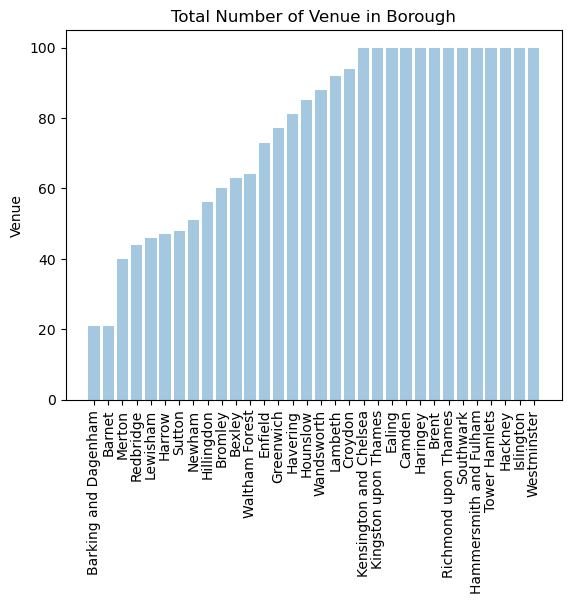

In [18]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
 
objects = summary.Borough
y_pos = np.arange(len(objects))
performance = summary.Count

plt.bar(y_pos, performance, align='center', alpha=0.4)
plt.xticks(y_pos, objects)
plt.ylabel('Venue')
plt.title('Total Number of Venue in Borough')
plt.xticks(rotation=90)

plt.show()

# fig 2#

Here we can see a nice steady line leading up to the boroughs with the most venues. This is fairly expected, most of the boroughs that have reached the maximum 100 venues are fairly central / highly populated areas in London. 

While this may be a good indication of venues in a borough, it is certainly not concrete evidence. This relies on the number of venues that not only Foursquare is aware of but also within the radius centred on the Long and Lat provided in the dataframe.

In [19]:
print('There are {} uniques categories.'.format(len(london_venues['Venue Category'].unique())))

There are 256 uniques categories.


#### **B.4. Analyzing Each Borough**

In [20]:
# one hot encoding
london_onehot = pd.get_dummies(london_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
london_onehot['Borough'] = london_venues['Borough'] 

# move neighborhood column to the first column
list_column = london_onehot.columns.tolist()
number_column = int(list_column.index('Borough'))
list_column = [list_column[number_column]] + list_column[:number_column] + list_column[number_column+1:] 
london_onehot = london_onehot[list_column]

london_onehot.head()

,Borough,Afghan Restaurant,African Restaurant,Airport,Airport Service,American Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,...,Tunnel,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Windmill,Wine Bar,Wine Shop,Yoga Studio
0,Barking and Dagenham,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Barking and Dagenham,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,Barking and Dagenham,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Barking and Dagenham,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Barking and Dagenham,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Next, let's group rows by borough and by taking the mean of the frequency of occurrence of each category

In [21]:
london_grouped = london_onehot.groupby('Borough').mean().reset_index()
london_grouped.head()

,Borough,Afghan Restaurant,African Restaurant,Airport,Airport Service,American Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,...,Tunnel,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Windmill,Wine Bar,Wine Shop,Yoga Studio
0,Barking and Dagenham,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.047619,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
1,Barnet,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
2,Bexley,0.0,0.0,0.0,0.0,0.031746,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.015873,0.015873,0.015873,0.0,0.0,0.0,0.0
3,Brent,0.0,0.0,0.0,0.0,0.020000,0.0,0.0,0.0,0.0,...,0.0,0.010000,0.0,0.000000,0.000000,0.010000,0.0,0.0,0.0,0.0
4,Bromley,0.0,0.0,0.0,0.0,0.016667,0.0,0.0,0.0,0.0,...,0.0,0.016667,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0


#### Let's put that into a pandas dataframe

In [22]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [23]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Borough']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
boroughs_venues_sorted = pd.DataFrame(columns=columns)
boroughs_venues_sorted['Borough'] = london_grouped['Borough']

for ind in np.arange(london_grouped.shape[0]):
    boroughs_venues_sorted.iloc[ind, 1:] = return_most_common_venues(london_grouped.iloc[ind, :], num_top_venues)

boroughs_venues_sorted.head()

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Barking and Dagenham,Park,Grocery Store,Supermarket,Bus Stop,Soccer Field,Discount Store,Soccer Stadium,Clothing Store,Pub,Gym
1,Barnet,Grocery Store,Park,Pub,Italian Restaurant,Dance Studio,Residential Building (Apartment / Condo),Cricket Ground,Plaza,Pizza Place,Fish & Chips Shop
2,Bexley,Pub,Fast Food Restaurant,Clothing Store,Coffee Shop,Supermarket,Hotel,Grocery Store,Museum,Chinese Restaurant,Pharmacy
3,Brent,Coffee Shop,Clothing Store,Hotel,Grocery Store,Indian Restaurant,Bar,Sporting Goods Shop,Sandwich Place,Supermarket,Pizza Place
4,Bromley,Pub,Coffee Shop,Clothing Store,Pizza Place,Gym / Fitness Center,Grocery Store,Bar,Café,Supermarket,Electronics Store


#### **B.5. Cluster of Boroughs**

K-Means algorithm is one of the most common cluster method of **unsupervised learning**. I will use K-Means algorithm for my study in this project.

First, I will run K-Means to cluster the boroughs into 2 clusters because when I analyze the K-Means with elbow method it ensured me the 3 degree for optimum k of the K-Means

In [24]:
# set number of clusters
kclusters = 3

london_grouped_clustering = london_grouped.drop('Borough', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(london_grouped_clustering)

# check cluster labels generated for each row in the dataframe
labels = kmeans.labels_
labels

array([1, 1, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 1,
       1, 2, 1, 0, 2, 0, 2, 0, 0, 2])

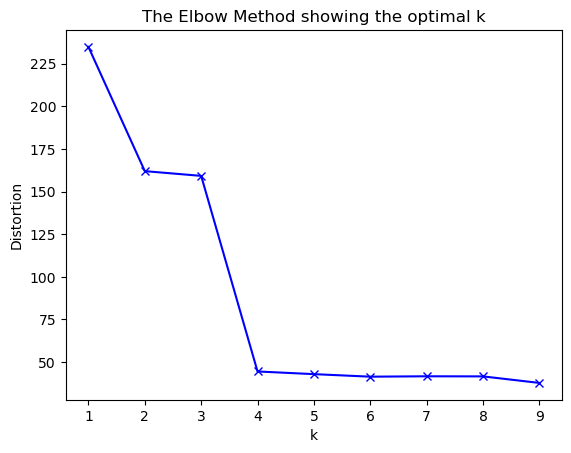

In [25]:
from scipy.spatial.distance import cdist

distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=0).fit(london_grouped_clustering)
    #kmeanModel.fit(london_grouped_clustering)
    distortions.append(sum(np.min(cdist(london_grouped_clustering, kmeanModel.cluster_centers_, 'canberra'), axis=1)) / london_grouped_clustering.shape[0])

#There are different metric distance function for spatial distance. 
#I choose correlation instaed of euclidean because the canberra function gives me more clear view of elbow break point.

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

# fig 3#

In [26]:
london_merged = london_data

# add clustering labels
london_merged['Cluster Labels'] = kmeans.labels_

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
london_merged = london_merged.join(boroughs_venues_sorted.set_index('Borough'), on='Borough')

london_merged.head() # check the last columns!

,Borough,Political control,Area (sq mi),Population (2019 est)[1],Rent,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Barking and Dagenham,Labour,13.93,"212,906",95.516082,51.560,0.1557,1,Park,Grocery Store,Supermarket,Bus Stop,Soccer Field,Discount Store,Soccer Stadium,Clothing Store,Pub,Gym
1,Barnet,Conservative,33.49,"395,896",101.374365,51.625,-0.1517,1,Grocery Store,Park,Pub,Italian Restaurant,Dance Studio,Residential Building (Apartment / Condo),Cricket Ground,Plaza,Pizza Place,Fish & Chips Shop
2,Bexley,Conservative,23.38,"248,287",NaN,51.454,0.1505,0,Pub,Fast Food Restaurant,Clothing Store,Coffee Shop,Supermarket,Hotel,Grocery Store,Museum,Chinese Restaurant,Pharmacy
3,Brent,Labour,16.70,"329,771",112.660721,51.558,-0.2817,2,Coffee Shop,Clothing Store,Hotel,Grocery Store,Indian Restaurant,Bar,Sporting Goods Shop,Sandwich Place,Supermarket,Pizza Place
4,Bromley,Conservative,57.97,"332,336",NaN,51.403,0.0198,0,Pub,Coffee Shop,Clothing Store,Pizza Place,Gym / Fitness Center,Grocery Store,Bar,Café,Supermarket,Electronics Store


We can also estimate the number of **1st Most Common Venue** in each cluster.Thus, we can create a bar chart which may help us to find proper label names for each cluster.

In [27]:
count_venue = london_merged
count_venue = count_venue.drop(['Borough','Political control','Population (2019 est)[1]','Rent', 'Latitude', 'Longitude'], axis=1)
count_venue = count_venue.groupby(['Cluster Labels','1st Most Common Venue']).size().reset_index(name='Counts')

#we can transpose it to plot bar chart
cv_cluster = count_venue.pivot(index='Cluster Labels', columns='1st Most Common Venue', values='Counts')
cv_cluster = cv_cluster.fillna(0).astype(int).reset_index(drop=True)
cv_cluster

1st Most Common Venue,Coffee Shop,Grocery Store,Hotel,Indian Restaurant,Park,Pub
0,4,0,0,0,0,15
1,0,2,0,0,2,1
2,4,0,3,1,0,0


Text(0, 0.5, 'Clusters')

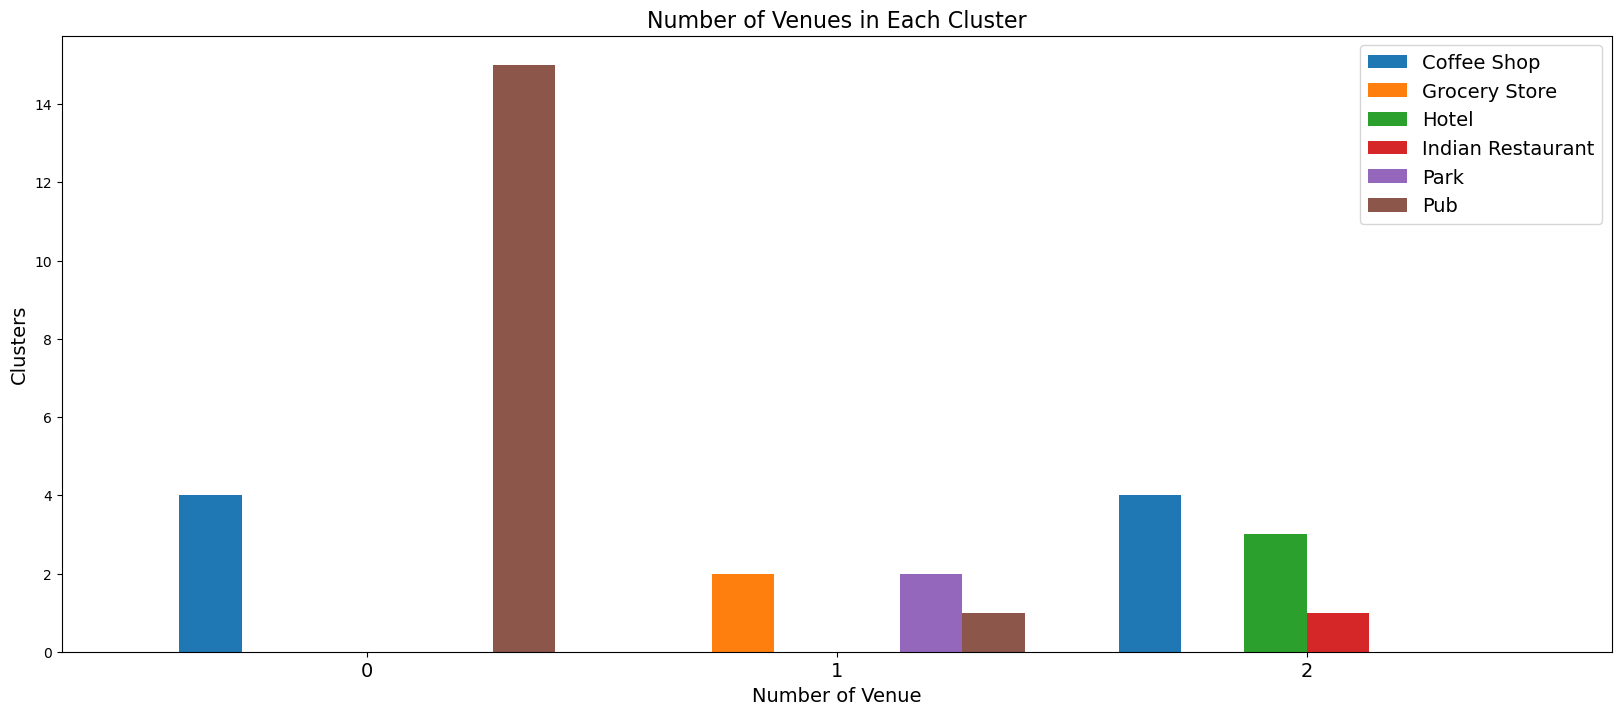

In [28]:
#creating a bar chart of "Number of Venues in Each Cluster"
frame=cv_cluster.plot(kind='bar',figsize=(20,8),width = 0.8)

plt.legend(labels=cv_cluster.columns,fontsize= 14)
plt.title("Number of Venues in Each Cluster",fontsize= 16)
plt.xticks(fontsize=14)
plt.xticks(rotation=0)
plt.xlabel('Number of Venue', fontsize=14)
plt.ylabel('Clusters', fontsize=14)

# fig 4#

When we examine above graph we can label each cluster as follows:
* Cluster 0 : "Cafe and Pub Venues"
* Cluster 1 : "Groceries and Parks"
* Cluster 2 : "Restaurants and Hotels"

We can now assign those new labels to existing label of clusters:

In [29]:
Cluster_labels = {'Clusters': [0,1,2], 'Labels': ["Cafe and Pub Venues","Groceries and Parks","Restaurants and Hotels"]}
Cluster_labels = pd.DataFrame(data=Cluster_labels)
Cluster_labels

,Clusters,Labels
0,0,Cafe and Pub Venues
1,1,Groceries and Parks
2,2,Restaurants and Hotels


In [30]:
data_process = df.sort_values('Rent').reset_index(drop=True)
data_process = data_process.drop(['Latitude', 'Longitude'], axis=1)
data_process.head()

,Borough,Political control,Area (sq mi),Population (2019 est)[1],Rent,Cluster Labels
0,Merton,Labour,14.52,"206,548",85.500000,1
1,Greenwich,Labour,18.28,"287,942",89.160000,0
2,Lewisham,Labour,13.57,"305,842",94.820000,1
3,Barking and Dagenham,Labour,13.93,"212,906",95.516082,1
4,Havering,Conservative,43.35,"259,552",96.502468,0


We can examine that what is the frequency of housing sales prices in different ranges. Thus, histogram can help to visualization

C:\Users\matt_\anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning:

invalid value encountered in greater_equal

C:\Users\matt_\anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning:

invalid value encountered in less_equal



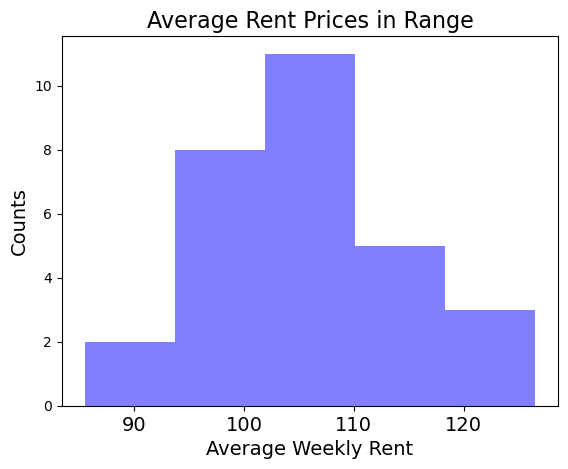

In [31]:
num_bins = 5
n, bins, patches = plt.hist(data_process['Rent'], num_bins, facecolor='blue', alpha=0.5)
plt.title("Average Rent Prices in Range",fontsize= 16)
plt.xticks(fontsize=14)
plt.xticks(rotation=0)
plt.xlabel('Average Weekly Rent', fontsize=14)
plt.ylabel('Counts', fontsize=14)
plt.show()

# fig 5

#### As it seems in above histogram, we can define the ranges as below:

* '>'90 Rent : "Low Level Rent"
* 90 - 100 Rent : "Mid-Low Level Rent"
* 100-110 Rent : "Mid Level Rent"
* 110-120 Rent : "Mid - High Level Rent"
* '>'120 Rent : "High Level Rent"

In this case, we can create **"Level_labels"** with those levels.

From figure 1, we notice that Labour controlled areas typically fall far under the average weekly rent, and Conservative and Lib Dem controlled much higher

In [32]:
level = []
for i in range(0,len(data_process)):
    if (data_process['Rent'][i] < 90):
        level.append("Low Level Rent")
    elif (data_process['Rent'][i] >= 90 and data_process['Rent'][i] < 100):
        level.append("Mid-Low Level Rent")
    elif (data_process['Rent'][i] >= 100 and data_process['Rent'][i] < 110):
        level.append("Mid Level Rent")
    elif (data_process['Rent'][i] >= 110 and data_process['Rent'][i] < 120):
        level.append("Mid-High Level Rent")
    else:
        level.append("High Level Rent")   

data_process['Level_labels'] = level
data_process.head()

,Borough,Political control,Area (sq mi),Population (2019 est)[1],Rent,Cluster Labels,Level_labels
0,Merton,Labour,14.52,"206,548",85.500000,1,Low Level Rent
1,Greenwich,Labour,18.28,"287,942",89.160000,0,Low Level Rent
2,Lewisham,Labour,13.57,"305,842",94.820000,1,Mid-Low Level Rent
3,Barking and Dagenham,Labour,13.93,"212,906",95.516082,1,Mid-Low Level Rent
4,Havering,Conservative,43.35,"259,552",96.502468,0,Mid-Low Level Rent


Showing the top 3 popular venue types in each borough will also help to identify niche areas of interest

In [44]:
top3 = london_venues.groupby(['Borough','Venue Category']).size().reset_index(name='Counts')
top3 = top3.sort_values(['Borough','Counts'],ascending=False).groupby('Borough').head(3).reset_index(drop=True)

top3['Join'] = top3['Counts'].map(str) + " " + top3['Venue Category']
top3 = top3.groupby(['Borough'])['Join'].apply(", ".join).reset_index()

top3.head(31)

,Borough,Join
0,Barking and Dagenham,"3 Park, 2 Bus Stop, 2 Grocery Store"
1,Barnet,"6 Grocery Store, 3 Park, 2 Pub"
2,Bexley,"10 Pub, 4 Clothing Store, 4 Fast Food Restaurant"
3,Brent,"9 Coffee Shop, 7 Clothing Store, 7 Hotel"
4,Bromley,"7 Pub, 5 Clothing Store, 5 Coffee Shop"
5,Camden,"7 Hotel, 5 Coffee Shop, 4 Bakery"
6,Croydon,"11 Pub, 6 Coffee Shop, 4 Clothing Store"
7,Ealing,"13 Coffee Shop, 11 Pub, 5 Italian Restaurant"
8,Enfield,"8 Pub, 5 Coffee Shop, 4 Clothing Store"
9,Greenwich,"7 Pub, 6 Grocery Store, 4 Fast Food Restaurant"


## **C. Results**

### **C.1. Main table with results**

In [34]:
import numpy as np

result = pd.merge(london_merged, 
                    top3[['Borough', 'Join']],
                    left_on = 'Borough',
                    right_on = 'Borough',
                    how = 'left')
result= pd.merge(result, 
                    Cluster_labels[['Clusters', 'Labels']],
                    left_on = 'Cluster Labels',
                    right_on = 'Clusters',
                    how = 'left')
result = pd.merge(result, 
                    data_process[['Borough', 'Level_labels']],
                    left_on = 'Borough',
                    right_on = 'Borough',
                    how = 'left')

result = result.drop(['Clusters'], axis=1)
result.head(3)

,Borough,Political control,Area (sq mi),Population (2019 est)[1],Rent,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,...,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Join,Labels,Level_labels
0,Barking and Dagenham,Labour,13.93,"212,906",95.516082,51.560,0.1557,1,Park,Grocery Store,...,Bus Stop,Soccer Field,Discount Store,Soccer Stadium,Clothing Store,Pub,Gym,"3 Park, 2 Bus Stop, 2 Grocery Store",Groceries and Parks,Mid-Low Level Rent
1,Barnet,Conservative,33.49,"395,896",101.374365,51.625,-0.1517,1,Grocery Store,Park,...,Italian Restaurant,Dance Studio,Residential Building (Apartment / Condo),Cricket Ground,Plaza,Pizza Place,Fish & Chips Shop,"6 Grocery Store, 3 Park, 2 Pub",Groceries and Parks,Mid Level Rent
2,Bexley,Conservative,23.38,"248,287",NaN,51.454,0.1505,0,Pub,Fast Food Restaurant,...,Coffee Shop,Supermarket,Hotel,Grocery Store,Museum,Chinese Restaurant,Pharmacy,"10 Pub, 4 Clothing Store, 4 Fast Food Restaurant",Cafe and Pub Venues,High Level Rent


Table on Political control and most common venue

In [43]:
top3pol = result.groupby(['Political control','1st Most Common Venue']).size().reset_index(name='Counts')
top3pol

,Political control,1st Most Common Venue,Counts
0,Conservative,Coffee Shop,2
1,Conservative,Grocery Store,1
2,Conservative,Hotel,1
3,Conservative,Pub,4
4,Labour,Coffee Shop,5
5,Labour,Grocery Store,1
6,Labour,Hotel,2
7,Labour,Indian Restaurant,1
8,Labour,Park,2
9,Labour,Pub,10


### **C.2. Map of Cluster Results**

Let's visualise out findings

In [50]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=9.5)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster, join, cluster_number, label in zip(result['Latitude'], result['Longitude'], result['Borough'], result['Labels'], result['Join'], result['Cluster Labels'], result['Level_labels']):
    label = folium.Popup(str(poi) + " / " + str(cluster) + "-" + str(label) + " / " + str(join), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        color= rainbow[cluster_number-1],
        popup=label,
        fill_color = rainbow[cluster_number-1],
        fill_opacity=1).add_to(map_clusters)
       
map_clusters

## **D. Discussion**

As expected of London and likely the majority of the UK, Pubs are the number 1 most popular venue in most boroughs. They're often the social hub of communities and the sheer number of them in comparison to other venues is impressive. Hotels are often found toward the centre which is also to be expected.

There are a few interesting exceptions to this though. Southwark has a variety of different venues ranging from Coffee shops to Pubs and hotels. It is very central and boasts mid levels of rent which is unusual considering it's location and compared to it's neibouring borough - one of which is Westminster which has some of the highest rents in London. Southwark also has London Bridge station which is easy to get to from different parts of london.

Camden is another interesting case. You would expect due to the popularity of it as a borough among the younger generation that there would be more pubs however this is not the case but perhaps there is room for some.

I wanted to look into the political control against favorourite venue but my findings were fairly clear: It doesn't matter what your political alighnment is in the UK, it seems that everyone loves going to the pub!


## **E. Conclusion**

I would advise business' and planners to consider accordingly what they aim to bring to London with their business. Pubs are the most common and seemingly popular venue in London, and a new well put together pub will likely always be succesful. One area to consider might be Soutwark for it's central location and relatively high population, as well as it's low rent in comparison to it's neighbouring boroughs.

## **F. References:**

* [1] [London - Wikipedia](https://en.wikipedia.org/wiki/List_of_London_boroughs)
* [2] [London Borough Weekly Rent Data](https://data.london.gov.uk/dataset/local-authority-average-rents)
* [3] [Forsquare API](https://developer.foursquare.com/)
